# 영화 리뷰 감성 분석

## 필수과제

### 1. 데이터셋 불러오기

In [13]:
import pandas as pd

df = pd.read_csv('./netflix_reviews.csv')

In [14]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,09ed2c3a-a4ca-4241-a01c-e7543943ee05,reyes Cruz,Very good experience. Great customer service.,5,0,7.89.0 build 18 35322,2024-10-20 14:10:34,7.89.0 build 18 35322
1,b2d324ff-0005-45c4-accf-dc983124400d,NISITH DISSANAYAKE (Widenn Gamer),Bro I was watching w cartoon then this error c...,1,0,8.136.0 build 3 50908,2024-10-20 14:10:25,8.136.0 build 3 50908
2,2d619b1e-aca3-4807-b77f-c9446a606ddf,Evelyn Okoro,Desent,5,0,NaN,2024-10-20 14:06:08,NaN
3,03cc29b9-a49a-4e26-885a-d1652bb669be,Yogesh Bhatta,THIS IS SCAM COMPANY.. THEY JUST LOOT PEOPLE M...,1,0,7.98.0 build 7 35414,2024-10-20 14:02:13,7.98.0 build 7 35414
4,c1b98dcf-0b75-4952-b9ac-6165381f41cf,P3L0NAZ0,Stopped opening. I've uninstalled and reinstal...,1,0,8.136.0 build 3 50908,2024-10-20 14:01:12,8.136.0 build 3 50908


In [15]:
df.tail()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
117035,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
117036,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
117037,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
117038,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346
117039,dc1352e9-10a8-41ca-ab23-05d045b08e90,suraj soni,"this app is awesome for english movies ,series...",4,0,NaN,2020-05-24 11:04:08,NaN


In [16]:
print(f'Shape of the dataset: {df.shape}')
print(f'Columns in the dataset: {df.columns}')

Shape of the dataset: (117040, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


### 2. 데이터 전처리

In [17]:
import re  # 정규 표현식을 사용하기 위함
import nltk  # natural language toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    pattern = r'[^a-zA-Z가-힣]'
    text = re.sub(r'[^a-zA-Z\s.!?,]', '', text)  # 알파벳, 공백, 그리고 일부 구두점만 유지
    return text

# 불필요한 열 제거
df = df[['content', 'score']]

# 리뷰 텍스트 정제
df['content'] = df['content'].apply(preprocess_text)

# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['content'] = df['content'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.head(20)

,content,score
0,good experience. great customer service.,5
1,bro watching w cartoon error came next season ...,1
2,desent,5
3,scam company.. loot people money name giftcard...,1
4,stopped opening. ive uninstalled reinstalled s...,1
5,phone cant watch netflix. stupid app,1
6,,1
7,beban q,1
8,z,5
9,"progress often saved, takes away core function...",1


### 3. feature 분석 (EDA)

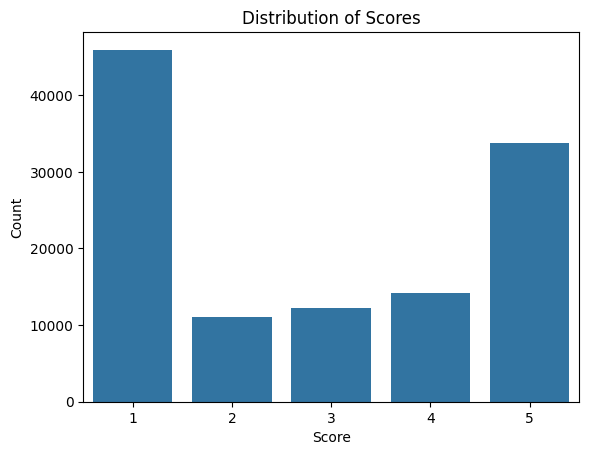

In [19]:
import seaborn as sns  # 그래프를 그리기 위한 seaborn 라이브러리 임포트 (없으면 설치 바랍니다)
import matplotlib.pyplot as plt  # 그래프 표시를 위한 pyplot 임포트

sns.countplot(x='score', data=df)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

### 4. 리뷰 예측 모델 학습시키기 (LSTM)


In [33]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import nltk

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
# 데이터 준비 (리뷰와 평점 컬럼을 추출)
reviews = df['content']
ratings = df['score']

In [36]:
# 단어 사전 구축 함수 정의 (리뷰 텍스트를 토큰화하고 사전 생성)
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

In [37]:
# 데이터셋 클래스 정의 (데이터셋을 커스텀하여 사용하기 위해 클래스 정의)
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return review, rating

In [38]:
# 패딩과 텐서 변환을 위한 collate 함수 정의
def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings, dtype=torch.long)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

In [39]:
# 텍스트 파이프라인 정의 (텍스트를 토큰화하고 텐서로 변환)
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)

In [40]:
# 레이블 파이프라인 클래스 정의 (평점을 수치화하여 모델에 입력)
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

In [41]:
# 레이블 파이프라인 초기화 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

#### LSTM model with ***Adam optimizer and Early stopping***

In [42]:
# 데이터 분할
# 훈련 데이터와 임시 데이터(검증 + 테스트 데이터) 분리(train_test_split 사용)
train_reviews, temp_reviews, train_ratings, temp_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 임시 데이터를 검증 데이터와 테스트 데이터로 분리(train_test_split 사용)
test_reviews, rtest_reviews, test_ratings, rtest_ratings = train_test_split(temp_reviews, temp_ratings, test_size=0.5, random_state=42)

# 인덱스 초기화 (데이터 프레임 인덱스 리셋)
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)
rtest_reviews.reset_index(drop=True, inplace=True)
rtest_ratings.reset_index(drop=True, inplace=True)

# 데이터셋 정의 (훈련 및 테스트 데이터셋 구성)
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)
rtest_dataset = ReviewDataset(rtest_reviews, rtest_ratings, text_pipeline, label_pipeline)

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 데이터 로더 정의 (DataLoader를 통해 배치로 데이터를 로딩)
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
rtest_dataloader = DataLoader(rtest_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [43]:
# 모델 정의 (LSTM 모델 구조를 설정하여 시퀀스 처리 수행)
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, output_dim)
)

  # 순전파 정의 (입력 텍스트를 임베딩하고 LSTM과 FC 계층에 통과)
  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded)  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))

# 단어 사전 생성 (훈련 데이터 리뷰를 기반으로 어휘 사전 구축)
vocab = build_vocab(train_reviews)

# 하이퍼파라미터 정의 (어휘 크기, 임베딩 차원, LSTM 은닉 차원 및 출력 차원 설정)
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 예측할 점수 개수

# 모델 초기화 (LSTM 모델 인스턴스 생성)
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의 (교차 엔트로피 손실과 Adam 사용, 학습률 0.01로 설정)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [44]:
# 조기 종료 함수 정의
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False


# 모델 학습 과정 정의 (Early Stopping 추가)
def train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10, patience=1):
    model.train()  # 모델을 학습 모드로 전환
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):
        total_loss = 0

        # 훈련 모드에서의 손실 계산
        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터
            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')

        # 테스트 손실 계산
        model.eval()  # 모델을 평가 모드로 전환
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_dataloader:
                reviews, ratings = batch  # 배치 데이터
                output = model(reviews)  # 모델의 출력
                test_loss = criterion(output, ratings)  # 테스트 손실 계산
                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Test Loss: {avg_test_loss:.4f}')

        # Early Stopping 체크
        if early_stopping(avg_test_loss):
            break  # 학습 중단

# 모델 학습 (훈련 함수 호출하여 모델 학습)
train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10, patience=3)

Epoch [1/10], Train Loss: 1.2433
Epoch [1/10], Test Loss: 1.0547
Epoch [2/10], Train Loss: 1.0122
Epoch [2/10], Test Loss: 1.0071
Epoch [3/10], Train Loss: 0.9604
Epoch [3/10], Test Loss: 1.0068
Epoch [4/10], Train Loss: 0.9299
Epoch [4/10], Test Loss: 1.0159
Epoch [5/10], Train Loss: 0.9106
Epoch [5/10], Test Loss: 1.0085
Epoch [6/10], Train Loss: 0.8898
Epoch [6/10], Test Loss: 1.0113
Early stopping triggered.


In [45]:
# 모델 평가 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for reviews, labels in loader:
            outputs = model(reviews)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 모델 평가
accuracy = evaluate(model, rtest_dataloader)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6386


## 추가 선택 과제

### 5. NLP 이용해보기

#### BERT model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import numpy as np
nltk.download('punkt')

In [ ]:
class TextPipeline:
    def __init__(self):
        self.vocab = {}

    def fit(self, texts):
        word_counts = Counter()
        for text in texts:
            words = word_tokenize(text)
            word_counts.update(words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items(), 1)}  # 1부터 시작

    def __call__(self, text):
        words = word_tokenize(text)
        return [self.vocab.get(word, 0) for word in words]  # 사전에 없는 단어는 0으로 처리

In [ ]:
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review, dtype=torch.long), torch.tensor(rating, dtype=torch.long)

In [ ]:
# 'content' 열이 문자열 형식인지 확인하고 변환
df['content'] = df['content'].astype(str)

In [ ]:
print(df.columns)

In [ ]:
# 텍스트 파이프라인 인스턴스 생성 및 학습
text_pipeline = TextPipeline()
text_pipeline.fit(df['content'].values)

# 레이블 파이프라인 인스턴스 생성 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 훈련 및 테스트 데이터를 설정
train_reviews = df['content'][:800].values  # 첫 800개는 훈련 데이터로
train_ratings = df['score'][:800].values
test_reviews = df['content'][800:].values   # 나머지는 테스트 데이터로
test_ratings = df['score'][800:].values

# 데이터셋 생성
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc(lstm_out[:, -1, :])  # 마지막 타임스텝 출력
        return out


In [ ]:
def train(model, loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for reviews, labels in loader:
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for reviews, labels in loader:
            outputs = model(reviews)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [ ]:
!pip install transformers

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
import os
os.environ["WANDB_DISABLED"] = "true"

# 데이터셋 클래스 정의
class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# 데이터셋 생성
max_length = 128
train_dataset = MovieReviewDataset(train_df['content'].values, train_df['sentiment'].values, tokenizer, max_length)
test_dataset = MovieReviewDataset(test_df['content'].values, test_df['sentiment'].values, tokenizer, max_length)

# 모델 준비
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(df['sentiment'])))

# 트레이너 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# 모델 학습
trainer.train()

# 평가
trainer.evaluate()

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# 환경 설정
os.environ["WANDB_DISABLED"] = "true"

# 데이터셋 분리
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 데이터셋 클래스 정의
class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# 데이터셋 생성
max_length = 128
train_dataset = MovieReviewDataset(train_df['content'].values, train_df['sentiment'].values, tokenizer, max_length)
test_dataset = MovieReviewDataset(test_df['content'].values, test_df['sentiment'].values, tokenizer, max_length)

# 모델 준비
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(df['sentiment'])))

# 평가를 위한 함수 정의
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # 예측값 중 가장 높은 점수를 가진 클래스로 선택
    acc = accuracy_score(labels, preds)  # 정확도 계산
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # 정밀도, 재현율, F1 점수
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 트레이너 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # 평가 지표 추가
)

# 모델 학습
trainer.train()

# 평가
eval_result = trainer.evaluate()

# 평가 결과 출력
print(f"Evaluation Results: {eval_result}")

# 정확도만 따로 출력
accuracy = eval_result['eval_accuracy']
print(f"Accuracy: {accuracy}")


### 6. 긍정 / 부정 리뷰의 워드 클라우드 그려보기

#### Negative word cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 텍스트파일 열기
text_negative = open('./negative.txt').read()
# 마스크 이미지 가져오기
alice_mask = np.array(Image.open('./alice_mask.png'))

# 불용어 지정
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'movies', 'show', 'shows', 'watch', 'account', 'time', 'app', 'series', 'phone', 'good','use','now','cant','dont','even'])

# 이미지 확인
plt.figure(figsize = (8,8))
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 단어들 설정과 빈도분석
wc = WordCloud(background_color = 'white', max_words = 500, mask = alice_mask, stopwords=stopwords)
wc = wc.generate(text_negative)

# 워드클라우드생성
plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud', size=20)
plt.axis('off')
plt.show()

#### Positive word cloud

In [ ]:
# 텍스트파일 열기
text_positive = open('./positive.txt').read()
# 마스크 이미지 가져오기
alice_mask = np.array(Image.open('./alice_mask.png'))

# 불용어 지정
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'movies', 'show', 'shows', 'watch', 'account', 'time', 'app', 'series', 'phone','use','now','problem','cant','dont','even'])

# 이미지 확인
plt.figure(figsize = (8,8))
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 단어들 설정과 빈도분석
wc = WordCloud(background_color = 'white', max_words = 500, mask = alice_mask, stopwords=stopwords)
wc = wc.generate(text_positive)

# 워드클라우드생성
plt.figure(figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud', size=20)
plt.axis('off')
plt.show()